# Step 3

In this section, we are going to use a Convolutional Neural Network (CNN) to predict the evolution of stock features in the future.

To perform CNN on our time series data, we first need to use the Gramian Angular Field (GAF) to transform the data into images. The dataset is built based on a 30-day time series. After applying GAF, we also rescale the data so that the values lie within the unit interval (between 0 and 1). The label indicates whether the time series increased or decreased over the following 7 days.

Before training the model, we perform fine tuning to obtain the best hyperparameters.

- **Dropout**e tuner choose between a value for dropout of 0.2 or 0.
- **Number of Convolutional layers in the model**: tuner choose between 1 and 3 hidden layers in the model.
- **Number of output layer in each Convolutional layers**: tuner choose between 8 (min_value) and 32 (max_value) units in each layer, with a step size of 16.
- **Kernel size in each Convolutional layers**: tuner choose between 2 or 3 
- **Pooling kernel size after Convolutional layers**: tuner choose between 2 or 3 3.
- **Number Dense of layers in the model**: tuner choose between 1 a3d 5 hidden layers in the modod.
- **Number of units in each hidden layer**: the tuner will choose betw8en 1 (min_value) 32d 25 (max_value) units in each layer, with a step size8o
- **Learning rate**: the tuner will choose between 8 (min_value) and 32 (max_value) f 5.


Because our dataset is limited, and to avoid overfitting, we will build a simple CNN model with the following structure:

- Input layer: Reads the data as a 3-dimensional tensor of shape 30x30x1.
- First Convolutional layer: Has 8 output channels and kernels of size 2x2. After applying convolution, we use a ReLU activation function and then a 2x2 max-pooling layer. We keep the first convolutional layer without tuning to make sure our model is CNN.
- Other Convolutional layer, depending on tuning: After applying convolution, we use a ReLU activation function and then a max-pooling layer.
- Flatten layer: Reshapes the data into a 1-dimensional tensor.
- Fully connected layer, depending on tuning: uses a ReLU activation function, and applies a dropout rate 
- Output layer: A single neuron with a sigmoid activation function, representing the probability of the label.

To train the model, we compile it using the Adam optimizer with tuned learning rate and binary cross-entropy loss as the objective function. There is no need to adjust the class weights because our dataset is fairly balanced between the two labels.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner as kt
from keras_tuner import HyperModel
from kerastuner import RandomSearch

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report


try:
    from pyts.image import GramianAngularField
except:
    !pip install pyts --quiet
    from pyts.image import GramianAngularField

import warnings
warnings.filterwarnings('ignore')

In [177]:
def load_data(file_path):
    df = pd.read_feather(file_path)
    df["ret"] = df["Adj Close"].pct_change()
    return df

def add_features(df, col):
    for i in range(1, 30):
        df[f"hist_{i}"] = df[col].shift(i)        
    df["shifted_output"] = df[col].shift(-7)
    df["Output"] = np.where((df["shifted_output"] - df[col]) > 0, 1, 0)
    df.dropna(inplace=True)

def prepare_training_set(df, col):
    X = np.array(df[[col, *(f"hist_{i}" for i in range(1, 30))]])
    y = np.array(df["Output"])

    # Transform to image using GAF
    transformer = GramianAngularField()
    X_new= transformer.transform(X)

    # Determine the examples to be used as inputs in the model and rescale them to the [0,1] scale
    for i in range(X_new.shape[0]):
        X_new[i] = (X_new[i] - np.min(X_new[i])) / (
            np.max(X_new[i]) - np.min(X_new[i])
        )

    return train_test_split(X_new, y, test_size=0.2, shuffle=False)


class CNN_model(HyperModel):
    def build(self, hp):
        act_fun = "relu"
        n_dropout = hp.Choice("n_dropout", values=[0.2, 0.3])
        n_pool = hp.Choice("n_pool", values=[2, 3])

        # Create model
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 1)))

        # The first CNN layer
        model.add(tf.keras.layers.Conv2D(8, 2, activation="relu"))    
        model.add(tf.keras.layers.MaxPooling2D(2))

        # Add CNN layers
        for i in range(1, hp.Int("conv_num_layers", 1, 3)):
            model.add(tf.keras.layers.Conv2D(
                filters=hp.Int('conv_filter_' + str(i), min_value=8, max_value=32, step=16),
                kernel_size=hp.Choice('conv_kernel_' + str(i), values = [2,3]),
                activation=act_fun))  
            model.add(tf.keras.layers.MaxPooling2D(n_pool))
        
        model.add(tf.keras.layers.Flatten())       
        for j in range(1, hp.Int("dense_num_layers", 1, 3)):   
            model.add(tf.keras.layers.Dense(
                    units=hp.Int("dense_units_" + str(j), min_value=8, max_value=32, step=8),
                    activation=act_fun,))
            model.add(tf.keras.layers.Dropout(n_dropout))

        model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

        
        # Compile model 
        hp_lr =  hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        #hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        model.compile(loss="binary_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), 
                  metrics=["accuracy"])

        return model

def tuning_model(X_train, y_train, tuner_method = "RandomSearch"):
    mod = CNN_model()
    if tuner_method == "RandomSearch":
        tuner = RandomSearch(mod,
                        objective=kt.Objective("val_loss", direction="min"),
                        seed=1234,
                         max_trials = 30,
                         overwrite=True,)
    else:
        tuner = kt.Hyperband(
            mod,
            objective=kt.Objective("val_loss", direction="min"), 
            overwrite=True, # overwrite results
            max_epochs=30,
            seed=1234,)
        
    
    
    tuner.search(
        X_train, 
        y_train,
        validation_split=0.2,
        shuffle = False,
        epochs=30)

    
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    best_model = tuner.hypermodel.build(best_hps) 

    
    # fit the model
    best_model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=32,
        verbose=2,
    )

    return best_model, best_hps.values
    


def evaluation_model(model, X_data,y_data):
    y_prob = model.predict(X_data)
    y_pred = np.round(y_prob)
    cm = metrics.confusion_matrix(y_data, y_pred)
    cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
    cm.plot(values_format="", cmap="Blues")
    print(classification_report(y_data, y_pred))
    return y_pred.flatten()

def backtesting(data, pred):
    df = pd.DataFrame(data["ret"][-len(pred):])
    df["position_long_short"] = np.where(pred > 0, 1, -1)
    df["position_long_only"] = np.where(pred > 0, 1, 0)
    df["position_buy_and_hold"] = 1

    for strat in ["long_short", "long_only", "buy_and_hold"]:
        df[f"ret_{strat}"] = df[f"position_{strat}"].shift(1) * df["ret"]
        df[f"cumret_{strat}"] = df[f"ret_{strat}"].expanding().apply(lambda x: np.prod(1 + x) - 1)
    return df

def plot_trading_performance(trades):
    plt.figure(figsize=(20, 10))
    ax = plt.gca()
    for strat in ["long_short", "long_only", "buy_and_hold"]:
        trades.plot(y=f"cumret_{strat}", label=strat, ax=ax)

    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.grid()
    plt.show()

    

# a. Raw data

By performing the GAF transformation, we generated 1,635 images, each with a size of 30x30 pixels and a single channel, from the daily adjusted close prices of NVDA.

Then, we split the data into 2 sets:

- Training set: Used to train the parameters of the model.
- Test set: Used for evaluation.

In [146]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

df_raw = load_data(file_path)
add_features(df_raw, "Adj Close")
X_train_raw, X_test_raw, y_train_raw, y_test_raw = prepare_training_set(df_raw, "Adj Close")

bestmodel_raw, besthyper_raw = tuning_model(X_train_raw, y_train_raw)

Trial 30 Complete [00h 00m 12s]
val_loss: 0.6543970704078674

Best val_loss So Far: 0.6456822752952576
Total elapsed time: 00h 04m 14s
Epoch 1/30
41/41 - 2s - 53ms/step - accuracy: 0.5856 - loss: 0.6811
Epoch 2/30
41/41 - 0s - 2ms/step - accuracy: 0.5879 - loss: 0.6767
Epoch 3/30
41/41 - 0s - 2ms/step - accuracy: 0.5879 - loss: 0.6760
Epoch 4/30
41/41 - 0s - 2ms/step - accuracy: 0.5879 - loss: 0.6750
Epoch 5/30
41/41 - 0s - 2ms/step - accuracy: 0.5879 - loss: 0.6732
Epoch 6/30
41/41 - 0s - 2ms/step - accuracy: 0.5872 - loss: 0.6716
Epoch 7/30
41/41 - 0s - 2ms/step - accuracy: 0.5879 - loss: 0.6693
Epoch 8/30
41/41 - 0s - 2ms/step - accuracy: 0.5902 - loss: 0.6657
Epoch 9/30
41/41 - 0s - 2ms/step - accuracy: 0.5910 - loss: 0.6614
Epoch 10/30
41/41 - 0s - 2ms/step - accuracy: 0.6032 - loss: 0.6549
Epoch 11/30
41/41 - 0s - 2ms/step - accuracy: 0.6101 - loss: 0.6483
Epoch 12/30
41/41 - 0s - 2ms/step - accuracy: 0.6216 - loss: 0.6410
Epoch 13/30
41/41 - 0s - 2ms/step - accuracy: 0.6399 - lo

In [147]:
print("Best Hyperparameters: ", besthyper_raw)
print(bestmodel_raw.summary())

Best Hyperparameters:  {'n_dropout': 0.3, 'n_pool': 3, 'conv_num_layers': 2, 'dense_num_layers': 1, 'lr': 0.005408347666390224, 'conv_filter_1': 8, 'conv_kernel_1': 3, 'dense_units_1': 8, 'conv_filter_2': 8, 'conv_kernel_2': 2}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261 (8.84 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,508 (5.89 KB)

None


In [ ]:
print("Performance of model on training data")
y_pred_raw = evaluation_model(bestmodel_raw, X_train_raw, y_train_raw)

Performance of model on testing data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

           0       0.41      0.38      0.39       123
           1       0.64      0.66      0.65       205

    accuracy                           0.56       328
   macro avg       0.52      0.52      0.52       328
weighted avg       0.55      0.56      0.56       328



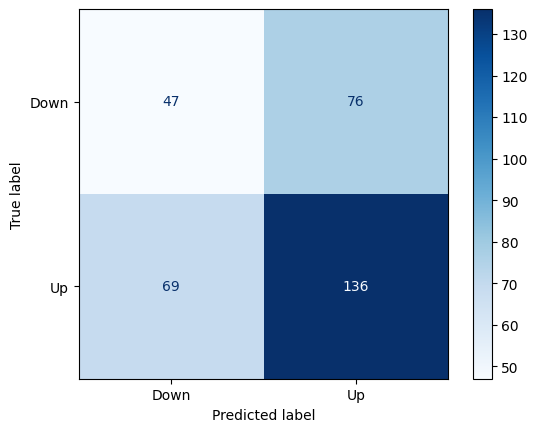

In [148]:
print("Performance of model on testing data")
y_pred_raw = evaluation_model(bestmodel_raw, X_test_raw, y_test_raw)

The CNN model trained on stock prices achieved an accuracy of 47%. All performance metrics on the testing set, including accuracy, precision, recall, and F1-score, were worse than those on the training set. This indicates overfitting, which can be partly explained by the fact that the number of observations is much smaller than the number of parameters in the model.

In [178]:
trades_raw = backtesting(df_raw, y_pred_raw)
trades_raw.tail()

,ret,position_long_short,position_long_only,position_buy_and_hold,ret_long_short,cumret_long_short,ret_long_only,cumret_long_only,ret_buy_and_hold,cumret_buy_and_hold
Date,,,,,,,,,,
2024-10-30 00:00:00+00:00,-0.013522,1,1,1,0.013522,-0.011363,-0.000000,0.823426,-0.013522,2.062251
2024-10-31 00:00:00+00:00,-0.047223,-1,0,1,-0.047223,-0.058049,-0.047223,0.737319,-0.047223,1.917643
2024-11-01 00:00:00+00:00,0.019886,1,1,1,-0.019886,-0.076780,0.000000,0.737319,0.019886,1.975662
2024-11-04 00:00:00+00:00,0.004801,1,1,1,0.004801,-0.072348,0.004801,0.745659,0.004801,1.989947
2024-11-05 00:00:00+00:00,0.028372,1,1,1,0.028372,-0.046029,0.028372,0.795187,0.028372,2.074778


In [ ]:
trades_raw.head()

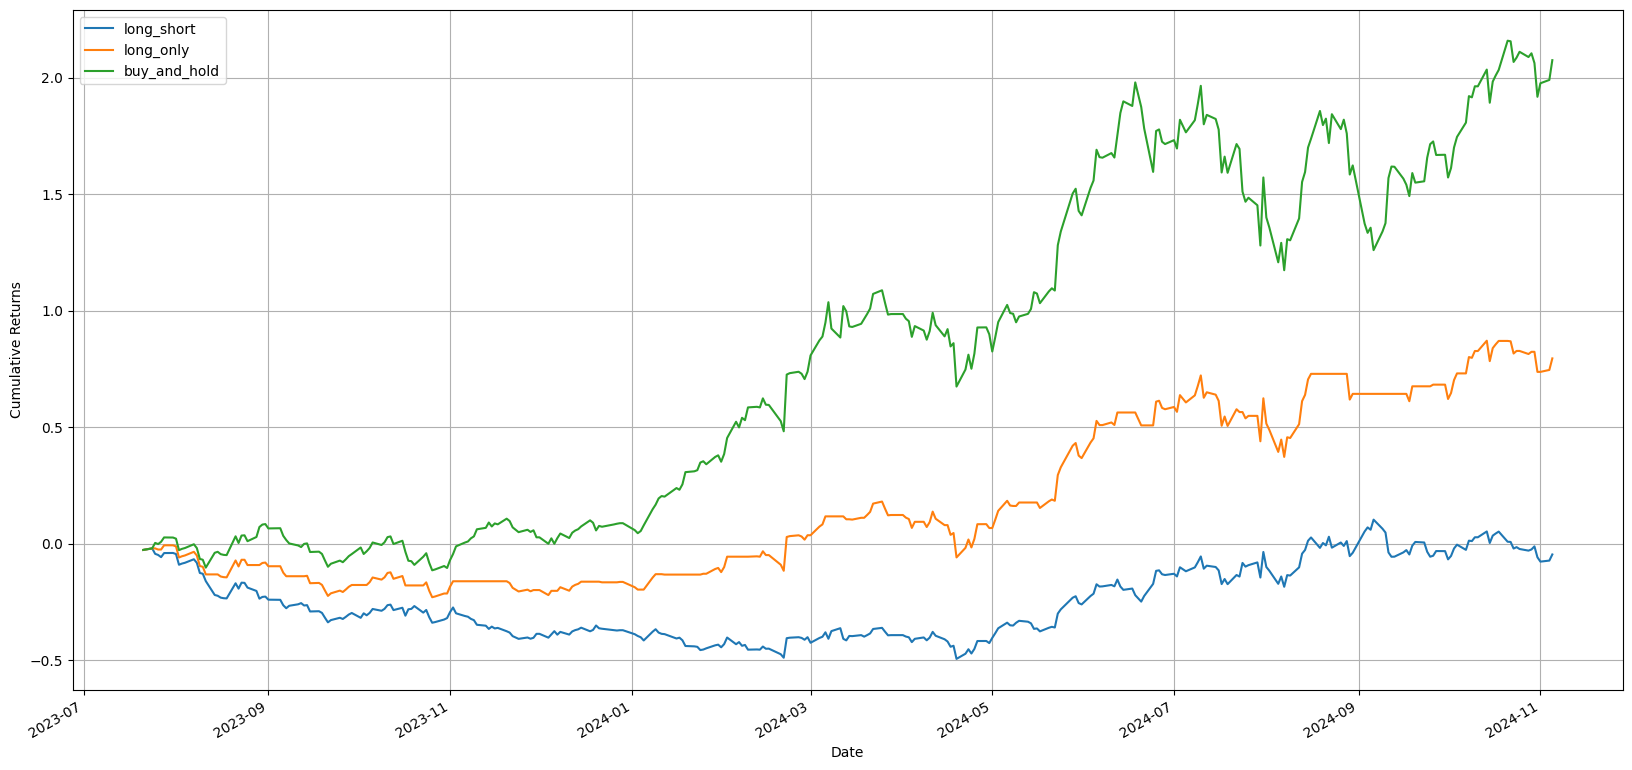

In [179]:
plot_trading_performance(trades_raw)


We can see the performance of model does not improve much. Sometimes, the best model after tuning does not include the Convolution layers.

## b. Stationary data

By performing the GAF transformation, we generated 1,635 images, each with a size of 30x30 pixels and a single channel, from the daily log returns of NVDA.

Then, we also split the data into 2 sets:

- Training set: Used to train the parameters of the model.
- Test set: Used for evaluation.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

df_stat = load_data(file_path)
add_features(df_stat, "Log Return")
X_train_stat, X_test_stat, y_train_stat, y_test_stat = prepare_training_set(df_stat, "Log Return")

bestmodel_stat, besthyper_stat = tuning_model(X_train_stat, y_train_stat)

Trial 24 Complete [00h 00m 10s]
val_loss: 0.6930232644081116

Best val_loss So Far: 0.6845610737800598
Total elapsed time: 00h 03m 47s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
0.2               |0.3               |n_dropout
2                 |2                 |n_pool
2                 |2                 |conv_num_layers
3                 |2                 |dense_num_layers
0.0014614         |0.0010473         |lr
8                 |8                 |conv_filter_1
3                 |2                 |conv_kernel_1
8                 |8                 |dense_units_1
8                 |None              |conv_filter_2
3                 |None              |conv_kernel_2
8                 |None              |dense_units_2

Epoch 1/30


In [ ]:
print("Best Hyperparameters: ", besthyper_stat)
print(bestmodel_stat.summary())

In [ ]:
print("Performance of model on training data")
y_pred_raw = evaluation_model(bestmodel_stat, X_train_stat, y_train_stat)

In [ ]:
print("Performance of model on testing data")
y_pred_stat = evaluation_model(bestmodel_stat, X_test_stat, y_test_stat)

The CNN model trained on daily log ruturn achieved an accuracy of 50%. For a stationary dataset, all performance metrics on the testing set, including accuracy, precision, recall, and F1-score, were still much worse than those on the training set. This indicates overfitting, which can be partly explained by the fact that the number of observations is much smaller than the number of parameters in the model.

In [ ]:
trades_stat = trading_performance(df_stat, y_pred_stat)
trades_stat.tail()

In [ ]:
plot_trading_performance(trades_stat)


We can see the performance of model does not improve much with stationary data as well. Sometimes, the best model after tuning does not include the Convolution layers.

Therefore, we can conclude that Convolutional model does not perform well on our data, at least for the chosen period.